In [33]:
import librosa

In [34]:
num_labels = 6 
emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
class_to_idx = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
idx_to_class = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip3 install pickle5
path_to_protocol5 = '/content/drive/MyDrive/Colab_Notebooks/Val_AFEW/enet_b0_8_FP16_afew.pickle'

import pickle5 as p
import pickle


with open(path_to_protocol5, "rb") as fh:
  train, val = p.load(fh)

In [37]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from scipy.special import softmax
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [38]:
DATA_DIR=r'/content/drive/MyDrive/Colab_Notebooks/AudioVideo1/AudioVideo'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

In [39]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_enet, y_test_enet, has_faces_test = create_dataset(val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [40]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train_enet,norm='l2')
x_test_norm=preprocessing.normalize(x_test_enet,norm='l2')

In [41]:
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=30, use_label_encoder=False)
 
clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
y_pred = clf.predict(x_test_norm)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5329815303430079
Complete accuracy: 0.5274151436031331


In [42]:
xgb_proba = clf.predict_proba(x_test_norm)

In [43]:
svc_clf1 = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf1.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = svc_clf1.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5936675461741425
Complete accuracy: 0.587467362924282


In [44]:
y_pred_proba = svc_clf1.decision_function(x_test_norm)
for i in range(len(y_pred_proba)):
  y_pred_proba[i] = softmax(y_pred_proba[i])


In [45]:
svc_clf = svm.SVC(C=1.1, probability=True) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = svc_clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5303430079155673
Complete accuracy: 0.5248041775456919


In [46]:
y_pred_prob = svc_clf.predict_proba(x_test_norm)

In [47]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion1 = pd.crosstab(y_test_enet, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion1.columns = classes
confusion1.index = classes

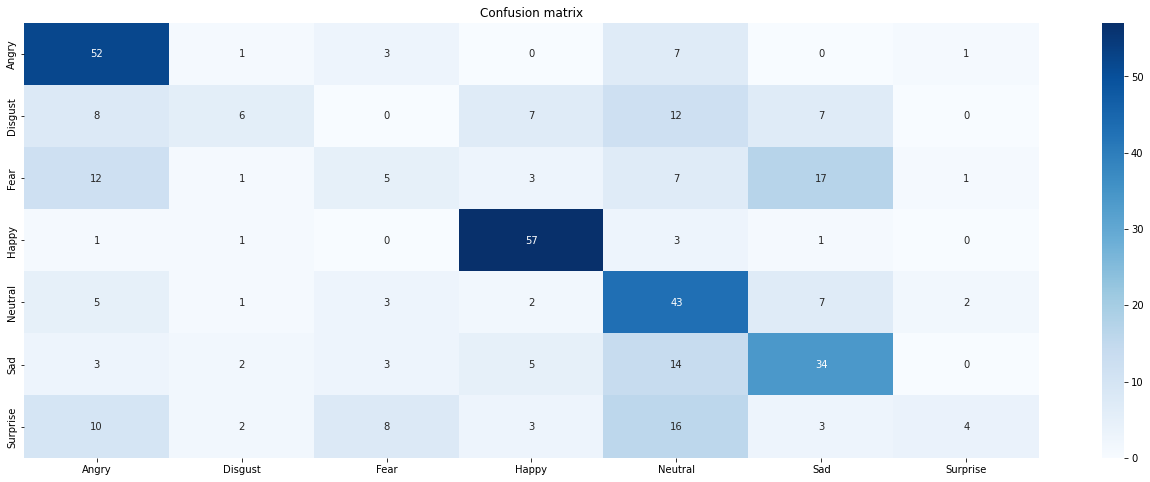

In [48]:
fig = plt.figure(figsize=(50,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
sns.heatmap(confusion1, annot=True, cmap='Blues', fmt='g')

In [49]:
!pip install openvino-dev[EXTRAS]
!pip install transformers==4.11.3
!pip install openvino

In [50]:
import torchaudio
import torch
import numpy as np
from transformers import AutoConfig, Wav2Vec2Processor, AutoModelForAudioClassification

In [51]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate

In [52]:
def preprocess_function_eval(speech_path):   
    speech_array, sampling_rate = librosa.load(speech_path, sr = 16000)
    result = processor(speech_array, sampling_rate=target_sampling_rate, max_length=50000, padding=True, truncation=True, return_attention_mask=True)
    len_of_input_data = result['input_values'][0].shape[0]
    padded_array = np.pad(result['input_values'][0], ((0,50000-len_of_input_data)), constant_values=0)
    return padded_array

In [53]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id=class_to_idx,
    id2label=idx_to_class,
    finetuning_task="wav2vec2_clf",    
)
setattr(config, 'pooling_mode', pooling_mode)

In [54]:
model = AutoModelForAudioClassification.from_pretrained(
    '/content/drive/MyDrive/Colab_Notebooks/group_course_work/hugging_face_w2v2', # <- insert folder with xml, config and bin
    num_labels=6,
    label2id=class_to_idx,
    id2label=idx_to_class,
) # acc 0.415144

In [55]:
from openvino.runtime import Core

ie = Core()
classification_model_xml = "/content/drive/MyDrive/Colab_Notebooks/group_course_work/fp16_w2v2/wav2vec2.xml" #<- insert here xml file where folder contains .bin weight file
model = ie.read_model(model=classification_model_xml)
model.reshape([1, 50000])
compiled_model = ie.compile_model(model=model, device_name="CPU") 
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [56]:
import pathlib 

path = pathlib.Path('/content/drive/MyDrive/Colab_Notebooks/Val_AFEW_Audio')

emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
prob_audio = [] 

for emotion_name in emotions_list: 
  audio_path = path/emotion_name
  for audio in audio_path.iterdir():
    prob_audio.append(compiled_model([np.expand_dims(preprocess_function_eval(audio), 0)])[output_layer])

In [57]:
prob_audio1 = prob_audio
for i in range(len(prob_audio)):
  prob_audio1[i] = softmax(prob_audio[i])

In [58]:
import time 

In [79]:
final_prob = []
y_test = []
max_prob = -1
index = -1
start_time = time.time()
for i in range(0, len(y_pred_proba)):
  final_prob.append(1.05*prob_audio[i]+0.45*y_pred_proba[i]+0.1*y_pred_prob[i]+0*xgb_proba)
  j = 0
  while j < len(final_prob[i][0]):
    if final_prob[i][0][j] > max_prob:
      index = j
      max_prob = final_prob[i][0][j]
    j += 1
  y_test.append(index)
  max_prob = -1
  index = -1
print("--- %s seconds ---" % (time.time() - start_time)) 
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, np.array(y_test)))

--- 0.024837970733642578 seconds ---
Complete accuracy: 0.597911227154047
